In [2]:
import matplotlib
%matplotlib inline
matplotlib.rcParams['font.size'] = 20.0
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import loadMWSnap as mws
import velocitySpectroscopyHelpers as vsh
reload(mws);
reload(vsh);

In [3]:
print mws.allHaloes

[268, 288, 374, 414, 416, 460, 490, 558, 570, 628, 878, 881, 530, 800, 852, 926, 937, 9829, 415, 8247, 567, 675, 14, 469, 641, 569, 573, 9749, 349, 967]


In [12]:
# load all haloes and compute their density profiles
reload(vsh);
reload(mws);

profiles = {}
eigs = {}
halo_list = [374] # mws.allHaloes

for i, halo in enumerate(halo_list):
    
    # load and radially bin particles
    print "Halo %d (%d of %d)"%(halo, i, len(halo_list))
    pos, vel, partmass, ldim, data = mws.loadMWSnap(halo=halo, verbose=False)

    # inner convergence radius from Calore+2016, 3*softening
    # TODO: check the actual "Power radius" for these sims (from Power+2002)
    p = vsh.mass_profile(pos, vel, partmass, rmin=2.8*.17/0.7, rmax=130.0, nbins=100)
    
    # conversion from m_sun/kpc^3 to GeV/cm^3
    to_gevcm3 = 3.977e-8
    
    # Get the axis ratio of the main halo particles inside the Sun's orbit
    rfilt = np.sum(pos**2, axis=1) < vsh.r_sun**2
    vals, vecs = np.linalg.eig(np.cov(pos[rfilt].T))
    vals = np.sort(vals)[::-1]
    b_a = vals[1]/vals[0]
    c_a = vals[2]/vals[0]
    
    # analytic NFW fits
    pnfw_rho, _ = curve_fit(vsh.nfw_rho, p['r'], p['rho'], sigma=p['sigma_rho'])
    pnfw_menc, _ = curve_fit(vsh.nfw_menc, p['r'], p['menc'], sigma=p['sigma_menc'])
    
    print pnfw_rho
    print pnfw_menc
    
    ff = lambda x: np.log(1.+x)-x/(1.+x)
    pnfw_rock = [1.*data['rs'], data['mvir']/(4.*np.pi*data['rs']**3*ff(data['rvir']/data['rs']))]
    print pnfw_rock

    profiles[halo] = p
    
# print allrho

Halo 374 (0 of 1)
[  2.29797278e+01   5.12856430e+06]
[  2.10394518e+01   6.18389903e+06]
[13.8468, 14107271.34195653]


In [10]:
print profiles[288].keys()

['sigma_rho', 'sigv_tot', 'sigma_menc', 'sigv_rad', 'r', 'rho', 'menc', 'sigv_tan']


[  2.29797278e+01   5.12856430e+06]
[19.781142857142857, 6912562.957558699]
[  2.10394518e+01   6.18389903e+06]


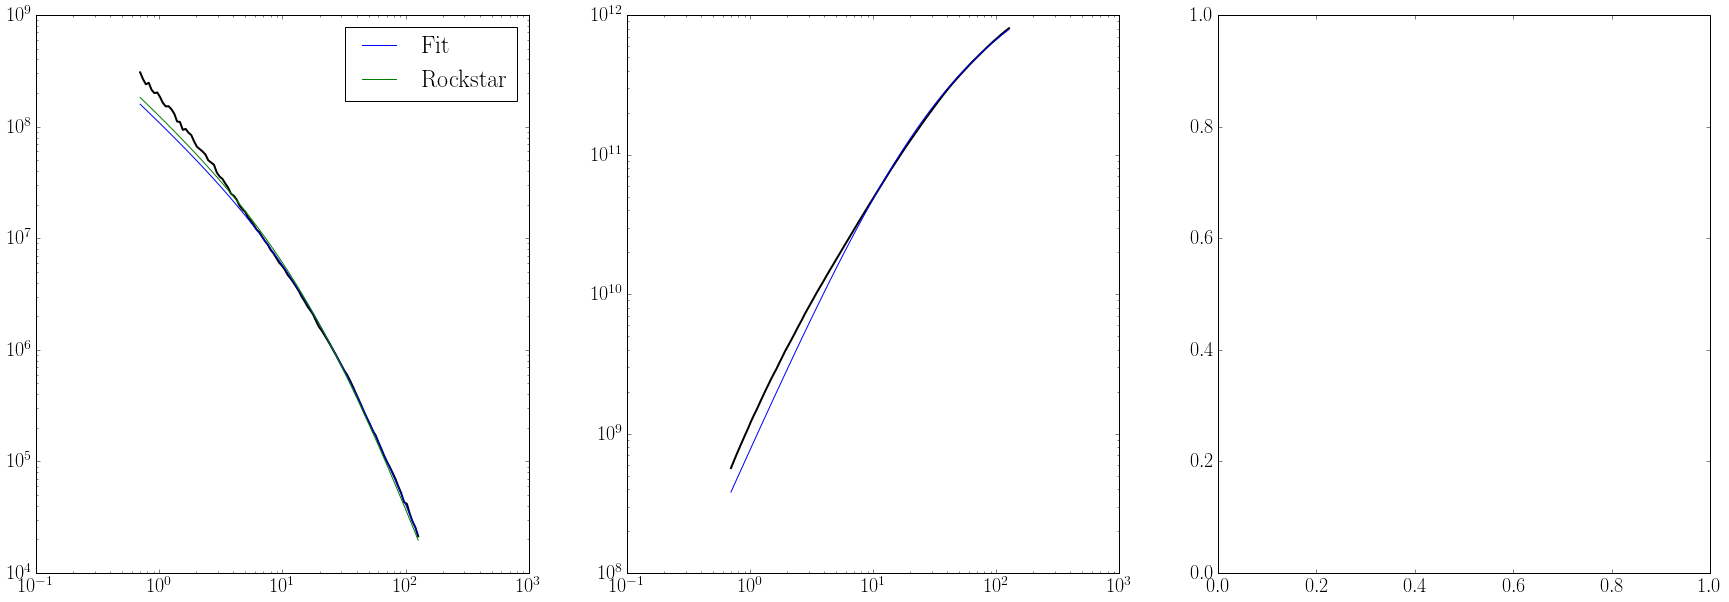

In [15]:
# density profile plot
fsz=10
fig, axes = plt.subplots(1, 3, figsize=(3*fsz, fsz))

# Plot profiles
for halo in profiles:
    p = profiles[halo]
    
    # density on the left
    pnfw_rho, _ = curve_fit(vsh.nfw_rho, p['r'], p['rho'], sigma=p['sigma_rho'])
    axes[0].loglog(p['r'], p['rho'], 'k', lw=2)
    axes[0].loglog(p['r'], vsh.nfw_rho(p['r'], *pnfw_rho), label='Fit')
    print pnfw_rho
    
    pnfw_rock[0] /= 0.7
    pnfw_rock[1] *= 0.7**2
    axes[0].loglog(p['r'], vsh.nfw_rho(p['r'], *pnfw_rock), label='Rockstar')
    print pnfw_rock
    
    axes[0].legend()
    
    # enclosed mass on the right
    pnfw_menc, _ = curve_fit(vsh.nfw_menc, p['r'], p['menc'], sigma=p['sigma_menc'])
    axes[1].loglog(p['r'], p['menc'], 'k', lw=2)
    axes[1].loglog(p['r'], vsh.nfw_menc(p['r'], *pnfw_menc), label='Pure NFW')
    print pnfw_menc
    
    # velocity dispersions
#     axes[2].semilogx(p['r'], p['sigv_rad'], 'k', lw=2)
#     axes[2].semilogx(p['r'], p['sigv_tan'], 'k', lw=2)
#     axes[2].semilogx(p['r'], p['sigv_tot'], 'k', lw=2)

# frills
# ax.set_title(r'$\rho(r)$, All Haloes')
# ax.set_xlabel(r'$r~\mathrm{[kpc]}$')
# ax.set_ylabel(r'$\rho~\mathrm{[GeV/cm^3]}$')
# ax.legend(fontsize=16)

In [5]:
# total, radial, and tangential speeds
rpart = np.sum(pos**2, axis=1)**0.5
rnorm = pos/rpart[:,None] # the unit vector to each particle
vrad = np.sum(vel*rnorm, axis=1) # the radial velocity component 
vtan = np.sum((vel-vrad[:,None]*rnorm)**2, axis=1)**0.5 # magnitude of the tangential velocity
vtot = np.sum(vel**2, axis=1)**0.5 # magnitude of the total velocity
# print np.max(np.abs(vtot**2-vrad**2-vtan**2))

# load Ranjan's data
analytic_nb = np.loadtxt('data/RadialVelocityDispersionNoBaryonTable937.dat').T
analytic_nb[1] *= 1.0e-3 # put in km/s
analytic = np.loadtxt('data/RadialVelocityDispersionTable937.dat').T
analytic[1] *= 1.0e-3 # put in km/s

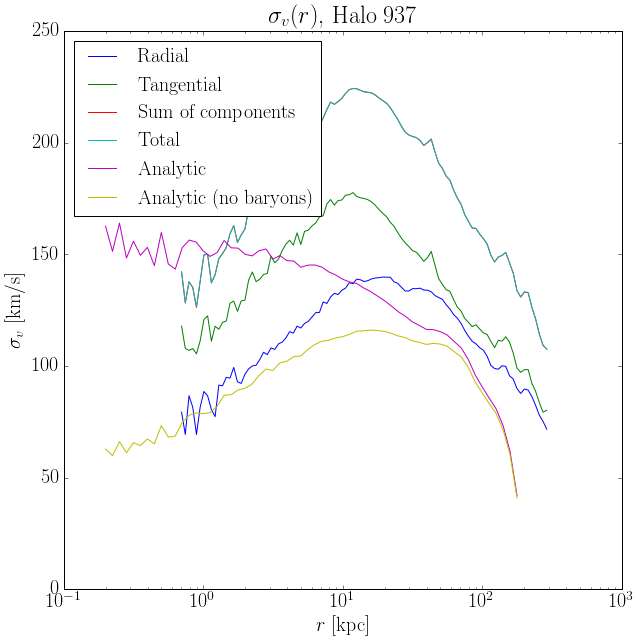

In [10]:
# calculate the velocity dispersion as a function of radius, using the bins from before
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

bins = np.logspace(np.log10(0.68), np.log10(300.), 100)
r = 0.5*(bins[:-1]+bins[1:])
# radial dispersion, need to incorporate mean velocity
num, bins = np.histogram(rpart, bins, weights=None)
vr_av, bins = np.histogram(rpart, bins, weights=vrad)
vr2_av, bins = np.histogram(rpart, bins, weights=vrad**2)
vr_av /= num
vr2_av /= num
sigma_rad = (vr2_av-vr_av**2)**0.5

# tangential dispersion, assume the mean is zero
vt2_av, bins = np.histogram(rpart, bins, weights=vtan**2)
sigma_tan = (vt2_av/num)**0.5

# total dispersion, assume the mean is zero
vtot2_av, bins = np.histogram(rpart, bins, weights=vtot**2)
sigma_tot = (vtot2_av/num)**0.5


# plot them
ax.semilogx(r, sigma_rad, label='Radial')
ax.semilogx(r, sigma_tan, label='Tangential')
ax.semilogx(r, (sigma_rad**2+sigma_tan**2)**0.5, label='Sum of components')
ax.semilogx(r, sigma_tot, label='Total')
ax.semilogx(analytic[0], analytic[1], label='Analytic')
ax.semilogx(analytic_nb[0], analytic_nb[1], label='Analytic (no baryons)')

# density profile plot
ax.set_title(r'$\sigma_v(r)$, Halo 937')
ax.set_xlabel(r'$r~\mathrm{[kpc]}$')
ax.set_ylabel(r'$\sigma_v~\mathrm{[km/s]}$')
ax.legend(loc='upper left', fontsize=20)

In [ ]:
# write to a text file
with open('data/rho_sigma_937.txt', 'w') as f:
    f.write('# Halo 937\n')
    f.write('# r (kpc)\trho (Gev/cm^3)\tsigma_tot (km/s)\tsigma_rad (km/s)\tsigma_tan (km/s)\n')
    np.savetxt(f, np.array([r, rho, vdisp["Total"], vdisp["Radial"], vdisp["Tangential"]]).T, fmt='%.8e', delimiter='\t')

In [ ]:
print partmass*len(rpart[rpart<200])

In [ ]:
raw=np.loadtxt('/nfs/slac/g/ki/ki21/cosmo/yymao/mw_resims/halos/Halo937/rockstar/out_235.list', usecols=(7,8,9,10,11,12,13), \
               dtype=np.dtype([('np', np.int32), ('cm', np.float64, (3,)), ('cv', np.float64, (3,))]))

In [ ]:
# print np.argmax(raw)
print np.argmax(raw['np'])
# print raw[14798]
# print raw

In [ ]:
import loadMWSnap as mws
reload(mws)

for halo in [937]: #mws.allHaloes:
    mws.loadMWSnap(halo=halo, verbose=True)




In [ ]:
# load all haloes and compute their density profiles
reload(vsh);
reload(mws);

profiles = {}
eigs = {}
halo_list = [374] # mws.allHaloes
# halo_list = [569, 573, 9749, 349, 967] #mws.allHaloes
# halo_list = mws.allHaloes

'''
# initialize the fit file
!rm profiles_130/fits_all_haloes
with open('profiles_130/fits_all_haloes', 'w') as f:
    f.write('# Best-fit parameters for all MW simulations\n')
    f.write('# id: simulation number\n')
    f.write('# rho_0(rho): rho_0 for NFW fit using binned rho, in GeV/cm^3\n')
    f.write('# r_s(rho): r_s for NFW fit using binned rho, in kpc\n')
    f.write('# rho_0(menc): rho_0 for NFW fit using binned menc, in GeV/cm^3\n')
    f.write('# r_s(menc): r_s for NFW fit using binned menc, in kpc\n')
    f.write('# b/a: principal axis ratio of halo for particles within the Sun\'s orbit\n')
    f.write('# c/a: principal axis ratio of halo for particles within the Sun\'s orbit\n')
    f.write('# id\trho_0(rho)\tr_s(rho)\trho_0(menc)\tr_s(menc)\tb/a\tc/a\n')
'''

for i, halo in enumerate(halo_list):
    
    # load and radially bin particles
    print "Halo %d (%d of %d)"%(halo, i, len(halo_list))
    pos, vel, partmass, data, ldim, data = mws.loadMWSnap(halo=halo, verbose=False)

    # inner convergence radius from Calore+2016, 3*softening
    # TODO: check the actual "Power radius" for these sims (from Power+2002)
    p = vsh.mass_profile(pos, vel, partmass, rmin=2.8*.17/0.7, rmax=130.0, nbins=100)
    
    # conversion from m_sun/kpc^3 to GeV/cm^3
    to_gevcm3 = 3.977e-8
    
    '''
    # write to file
    with open('profiles_130/halo%d.profile'%halo, 'w') as f:
        f.write('# Radially-binned profile for halo %d\n'%halo)
        f.write('# r: radius in kpc\n')
        f.write('# rho: density in GeV/cm^3\n')
        f.write('# sigma_rho: Poisson error for rho in GeV/cm^3\n')
        f.write('# menc: enclosed mass in M_sun\n')
        f.write('# sigma_menc: Poisson error for menc in M_sun\n')
        f.write('# vdisp_tot: total velocity dispersion in km/s\n')
        f.write('# vdisp_rad: radial velocity dispersion in km/s\n')
        f.write('# vdisp_tan: tangential velocity dispersion in km/s\n')
        f.write('# r\trho\tsigma_rho\tmenc\tsigma_menc\tvdisp_tot\tvdisp_rad\tvdisp_tan\n')
        for i in xrange(len(p['r'])):
            f.write('%.5e\t%.5e\t%.5e\t%.5e\t%.5e\t%.5e\t%.5e\t%.5e\n' % \
                    (p['r'][i], p['rho'][i]*to_gevcm3, p['sigma_rho'][i]*to_gevcm3, \
                     p['menc'][i], p['sigma_menc'][i], \
                     p['vdisp_tot'][i], p['vdisp_rad'][i], p['vdisp_tan'][i]))
    '''
    
    # Get the axis ratio of the main halo particles inside the Sun's orbit
    rfilt = np.sum(pos**2, axis=1) < vsh.r_sun**2
    vals, vecs = np.linalg.eig(np.cov(pos[rfilt].T))
    vals = np.sort(vals)[::-1]
    b_a = vals[1]/vals[0]
    c_a = vals[2]/vals[0]
    
    # analytic NFW fits
    pnfw_rho, _ = curve_fit(vsh.nfw_rho, p['r'], p['rho'], sigma=p['sigma_rho'])
    pnfw_menc, _ = curve_fit(vsh.nfw_menc, p['r'], p['menc'], sigma=p['sigma_menc'])
    '''
    with open('profiles_130/fits_all_haloes', 'a') as f:
        f.write('%d\t%.5e\t%.5e\t%.5e\t%.5e\t%.5e\t%.5e\n' % \
                (halo, pnfw_rho[1]*to_gevcm3, pnfw_rho[0], pnfw_menc[1]*to_gevcm3, pnfw_menc[0], b_a, c_a))
    '''
    profiles[halo] = p
    
# print allrho